In [1]:
!pip install gensim
import gensim

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [55]:
from google.colab import drive
drive.mount('/content/drive/')
file_path= '/content/drive/MyDrive/CSE440_Project/Question Answer Classification Dataset 1[Training].csv'

df = pd.read_csv(file_path)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **EDA**

In [4]:
df.shape

(279999, 2)

In [5]:
# df.head(10)

In [6]:
# df.isnull().sum()

In [7]:
# df['Class'].value_counts()

In [8]:
# class_counts = df['Class'].value_counts()

# plt.figure(figsize=(15, 5))
# class_counts.plot(kind='bar', color='lightgreen', edgecolor='black')

# plt.title("Class Distribution")
# plt.xlabel("Class")
# plt.ylabel("Count")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [9]:
# from wordcloud import WordCloud

# text = " ".join(df["QA Text"].astype(str))

# wordcloud = WordCloud(width=1600, height=900, background_color='black').generate(text)

# plt.figure(figsize=(12, 7))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()


# **Pre-processing**

In [57]:
# Lowercase conversion
df['QA Text'] = df['QA Text'].str.lower()

In [58]:
import re

# Punctuation and symbol removal (removes punctuation and special characters, keeping words and spaces)
df['QA Text'] = df['QA Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [59]:
# Whitespace normalization (remove extra spaces, tabs, newlines)
df['QA Text'] = df['QA Text'].apply(lambda x: ' '.join(x.split()))

In [60]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Tokenization (split into words/tokens)
df['tokens'] = df['QA Text'].apply(word_tokenize)
# Note: This creates a new column 'tokens' with lists of tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
from nltk.corpus import stopwords
nltk.download('stopwords')


# Stop word removal
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
from nltk.stem import WordNetLemmatizer


nltk.download('wordnet')
nltk.download('omw-1.4')




# Lemmatization
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [63]:
# Handle "QA Text" column: Extract only the question text by removing phrases like "Question Content:" or "Question Title:"
def extract_question(text):
    # Split by "Question Content:" or "Question Title:" and take the first part, strip whitespace
    patterns = [r'Question Content:', r'Question Title:']
    for pattern in patterns:
        if re.search(pattern, text, re.IGNORECASE):
            text = re.split(pattern, text, flags=re.IGNORECASE)[0].strip()
    return text

df['QA Text'] = df['QA Text'].apply(extract_question)

In [64]:
from sklearn.preprocessing import LabelEncoder

# Encode the "Class" column using LabelEncoder for numerical representation
label_encoder = LabelEncoder()
df['Class_encoded'] = label_encoder.fit_transform(df['Class'])


In [65]:
df.head(10)

,QA Text,Class,tokens,Class_encoded
0,question title have you liked a person who is ...,Family & Relationships,"[question, title, liked, person, bisexual, cou...",4
1,question title what is simulation question con...,Science & Mathematics,"[question, title, simulation, question, conten...",7
2,question title help to loose weight question c...,Health,"[question, title, help, loose, weight, questio...",5
3,question title did you know that the kkk adopt...,Business & Finance,"[question, title, know, kkk, adopted, highway,...",0
4,question title how can i find an old friend in...,Family & Relationships,"[question, title, find, old, friend, uk, quest...",4
5,question title best low start up cost business...,Business & Finance,"[question, title, best, low, start, cost, busi...",0
6,question title what makes you the happiest in ...,Family & Relationships,"[question, title, make, happiest, relationship...",4
7,question title how good is comcast hdtv questi...,Entertainment & Music,"[question, title, good, comcast, hdtv, questio...",3
8,question title how come im so dumb with everyt...,Family & Relationships,"[question, title, come, im, dumb, everything, ...",4
9,question title i love foto woman alder me ques...,Family & Relationships,"[question, title, love, foto, woman, alder, qu...",4


In [66]:
df.shape

(279999, 4)

# **MODELS**

In [67]:
# Data Preparation: Splitting dataset with heavy subsampling for memory optimization
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gc

# Subsample dataset to 20% to fit RAM---proposed
#0.8 = 80% -- Done here
df = df.sample(frac=0.8, random_state=42)  s
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Use smaller test size
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)  # ~50,400 train, 5,600 test

X_text_train = train_df['processed_text']
X_text_test = test_df['processed_text']
X_tokens_train = train_df['tokens']
X_tokens_test = test_df['tokens']
y_train = train_df['Class_encoded']
y_test = test_df['Class_encoded']

num_classes = df['Class_encoded'].nunique()

# Clear original df
# del df
gc.collect()
print(f"Subsampled dataset: Train {len(y_train)}, Test {len(y_test)}")

Subsampled dataset: Train 201599, Test 22400


In [68]:
# Tokenizer Setup: Converting text to sequences with reduced vocabulary and sequence length
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Hyperparameters  (reduced for memory efficiency)
MAX_NUM_WORDS = 10000  # Reduced from 20000
MAX_SEQUENCE_LENGTH = 100  # Reduced from 200

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_text_train)
word_index = tokenizer.word_index

X_seq_train = tokenizer.texts_to_sequences(X_text_train)
X_seq_test = tokenizer.texts_to_sequences(X_text_test)

X_pad_train = pad_sequences(X_seq_train, maxlen=MAX_SEQUENCE_LENGTH)
X_pad_test = pad_sequences(X_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

# Clear temporary variables
# del X_seq_train, X_seq_test
import gc
gc.collect()

0

**TRAINING (BEFORE BOW)**

In [23]:
# TF-IDF: Creating TF-IDF with reduced features and saving to disk
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse
import gc

max_features_tfidf = 3000  #5000

vectorizer_tfidf = TfidfVectorizer(max_features=max_features_tfidf)
X_tfidf_train = vectorizer_tfidf.fit_transform(X_text_train)
X_tfidf_test = vectorizer_tfidf.transform(X_text_test)

scipy.sparse.save_npz('/content/X_tfidf_train.npz', X_tfidf_train)
scipy.sparse.save_npz('/content/X_tfidf_test.npz', X_tfidf_test)

# del X_text_train, X_text_test
gc.collect()
print("TF-IDF matrices saved, memory cleared")

TF-IDF matrices saved, memory cleared


In [24]:
# GloVe Embeddings: Loading GloVe and creating embedding matrix and averages

# Hyperparameter
embedding_dim = 100
glove_file = '/content/drive/MyDrive/CSE440_Project/glove.6B.100d.txt'

embeddings_index_glove = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        word, coef = line.split(maxsplit=1)
        if word in word_index:  # Load only words in vocabulary
            coef = np.fromstring(coef, 'f', sep=' ')
            embeddings_index_glove[word] = coef

# Embedding matrix for neural networks
embedding_matrix_glove = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector

# Average embeddings for DNN
def get_average_glove(tokens):
    valid_vectors = [embeddings_index_glove[word] for word in tokens if word in embeddings_index_glove]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    return np.zeros(embedding_dim)

X_glove_avg_train = np.array([get_average_glove(tokens) for tokens in X_tokens_train])
X_glove_avg_test = np.array([get_average_glove(tokens) for tokens in X_tokens_test])

# Clear memory
del embeddings_index_glove
gc.collect()

0

In [25]:
# import numpy
# import gensim
# from gensim.models import Word2Vec
# import scipy # Import scipy to print its version
# print(f"NumPy version: {numpy.__version__}")
# print(f"Gensim version: {gensim.__version__}")
# print(f"SciPy version: {scipy.__version__}")

In [26]:
# Skip-gram Embeddings: Training Word2Vec skip-gram model with reduced parameters
from gensim.models import Word2Vec


# Hyperparameters  (reduced for memory)
embedding_dim = 50   # Reduced from 100
window_size = 3      # Reduced from 5
min_count = 5        # Increased to reduce vocabulary size
sg_epochs = 5        # Reduced from 10

# Train Word2Vec skip-gram model
sg_model = Word2Vec(sentences=X_tokens_train, vector_size=embedding_dim, window=window_size, min_count=min_count, workers=4, sg=1, epochs=sg_epochs)

# Create dictionary of word embeddings
embeddings_index_sg = {word: sg_model.wv[word] for word in sg_model.wv.index_to_key}

# Embedding matrix for neural networks
embedding_matrix_sg = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in embeddings_index_sg:
        embedding_matrix_sg[i] = embeddings_index_sg[word]

# Function to compute average embeddings for DNN
def get_average_sg(tokens):
    valid_vectors = [embeddings_index_sg[word] for word in tokens if word in embeddings_index_sg]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    return np.zeros(embedding_dim)

# Compute average embeddings
X_sg_avg_train = np.array([get_average_sg(tokens) for tokens in X_tokens_train])
X_sg_avg_test = np.array([get_average_sg(tokens) for tokens in X_tokens_test])

# Clear memory
del sg_model, embeddings_index_sg
gc.collect()

0

In [27]:
# # Skip-gram Embeddings: Training Word2Vec skip-gram model with reduced parameters
# from gensim.models import Word2Vec
# import numpy as np

# # Hyperparameters  (reduced for memory)
# embedding_dim = 50   # Reduced from 100
# window_size = 3      # Reduced from 5
# min_count = 5        # Increased to reduce vocabulary size
# sg_epochs = 5        # Reduced from 10

# # Train Word2Vec skip-gram model
# sg_model = Word2Vec(sentences=X_tokens_train, vector_size=embedding_dim, window=window_size, min_count=min_count, workers=4, sg=1, epochs=sg_epochs)

# # Create dictionary of word embeddings
# embeddings_index_sg = {word: sg_model.wv[word] for word in sg_model.wv.index_to_key}

# # Embedding matrix for neural networks
# embedding_matrix_sg = np.zeros((len(word_index) + 1, embedding_dim))
# for word, i in word_index.items():
#     if word in embeddings_index_sg:
#         embedding_matrix_sg[i] = embeddings_index_sg[word]

# # Function to compute average embeddings for DNN
# def get_average_sg(tokens):
#     valid_vectors = [embeddings_index_sg[word] for word in tokens if word in embeddings_index_sg]
#     if valid_vectors:
#         return np.mean(valid_vectors, axis=0)
#     return np.zeros(embedding_dim)

# # Compute average embeddings
# X_sg_avg_train = np.array([get_average_sg(tokens) for tokens in X_tokens_train])
# X_sg_avg_test = np.array([get_average_sg(tokens) for tokens in X_tokens_test])

# # Clear memory
# del sg_model, embeddings_index_sg
# gc.collect()

In [28]:
import gc
gc.collect()
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       4.2Gi       2.0Gi       2.0Mi       6.5Gi       8.1Gi
Swap:             0B          0B          0B


Num GPUs Available:  1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       768,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 802,442 (3.06 MB)

 Trainable params: 802,442 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Model summary:
None
Epoch 1/7
16757/16757 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.5848 - loss: 1.3024 - val_accuracy: 0.6944 - val_loss: 0.9379
Epoch 2/7
16757/16757 ━━━━━━━━━━━━━━━━━━━━ 10s 590us/step - accuracy: 0.6659 - loss: 1.0760 - val_accuracy: 0.7033 - val_loss: 0.9219
Epoch 3/7
16757/16757 ━━━━━━━━━━━━━━━━━━━━ 21s 159us/step - accuracy: 0.6875 - loss: 0.8865 - val_accuracy: 0.6999 - val_loss: 0.9318
Epoch 4/7
16757/16757 ━━━━━━━━━━━━━━━━━━━━ 2s 115us/step - accuracy: 0.7500 - loss: 0.7878 - val_accuracy: 0.7025 - val_loss: 0.9318
Epoch 5/7
16757/16757 ━━━━━━━━━━━━━━━━━━━━ 2s 116us/step - accuracy: 0.7500 - loss: 0.7335 - val_accuracy: 0.7018 - val_loss: 0.9269
Epoch 6/7
16757/16757 ━━━━━━━━━━━━━━━━━━━━ 2s 116us/step - accuracy: 0.7500 - loss: 0.7095 - val_accuracy: 0.6972 - val_loss: 0.9401
Epoch 7/7
16757/16757 ━━━━━━━━━━━━━━━━━━━━ 3s 155us/step - accuracy: 0.8125 - loss: 0.5693 - val_accuracy: 0.7138 - val_loss: 0.8921
Accuracy: 0.6712
F1 Macro: 0.6659
F1 Weighted: 0

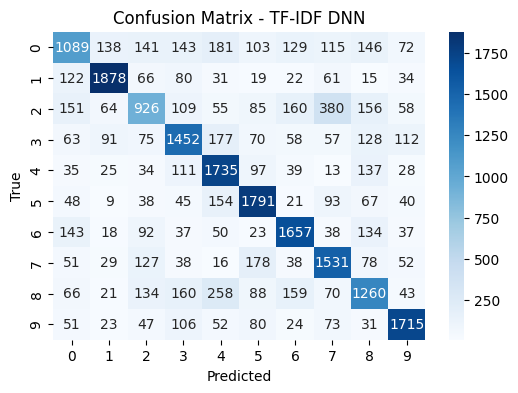

               total        used        free      shared  buff/cache   available
Mem:            12Gi       4.6Gi       1.2Gi        20Mi       6.9Gi       7.8Gi
Swap:             0B          0B          0B


In [29]:
# TF-IDF + Deep Neural Network: Optimized with generator for large dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc
import scipy.sparse


# Enable mixed precision
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Hyperparameters
hidden_units1 = 256
hidden_units2 = 128
dropout_rate = 0.3
epochs = 7
batch_size = 8
learning_rate = 0.0005
validation_split = 0.05
subsample_frac = 0.7

# Load TF-IDF if not in memory
if 'X_tfidf_train' not in globals():
    X_tfidf_train = scipy.sparse.load_npz('/content/X_tfidf_train.npz')
    X_tfidf_test = scipy.sparse.load_npz('/content/X_tfidf_test.npz')

# Subsample
subsample_idx = np.random.choice(len(y_train), int(len(y_train) * subsample_frac), replace=False)
X_tfidf_train_sub = X_tfidf_train[subsample_idx]
y_train_sub = y_train.iloc[subsample_idx].values

# Data generator
def data_generator(X_sparse, y, batch_size, shuffle=True):
    n_samples = X_sparse.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        batch_idx = indices[start:start + batch_size]
        X_batch = X_sparse[batch_idx].toarray().astype(np.float32)
        y_batch = y[batch_idx]
        yield X_batch, y_batch


gc.collect()

# Build model
model = Sequential([
    Dense(hidden_units1, input_shape=(X_tfidf_train_sub.shape[1],), activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(hidden_units2, activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"Model summary:\n{model.summary()}")

# Train with generator
steps_per_epoch = int((1 - validation_split) * len(y_train_sub) / batch_size)
val_steps = int(validation_split * len(y_train_sub) / batch_size)
train_gen = data_generator(X_tfidf_train_sub, y_train_sub, batch_size, shuffle=True)
val_gen = data_generator(X_tfidf_train_sub, y_train_sub, batch_size, shuffle=False)

with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps,
        epochs=epochs,
        verbose=1
    )

# Predict
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_tfidf_test.toarray().astype(np.float32), verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TF-IDF DNN')
plt.show()
plt.close()

# Save metrics
# results = {'Representation': 'TF-IDF', 'Model': 'Deep Neural Network',
#            'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
# results_df = pd.DataFrame([results])
# results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
# print("Metrics saved to model_results.csv")

# Clear memory
del model, y_pred_prob, y_pred, X_tfidf_train_sub, y_train_sub, history, train_gen, val_gen
gc.collect()
!free -h

Accuracy: 0.5251339285714286
F1 Macro: 0.5218979485096699
F1 Weighted: 0.5236697586275679
              precision    recall  f1-score   support

           0       0.60      0.29      0.39      2257
           1       0.68      0.68      0.68      2328
           2       0.47      0.24      0.32      2144
           3       0.48      0.45      0.47      2283
           4       0.51      0.73      0.60      2254
           5       0.66      0.55      0.60      2306
           6       0.62      0.62      0.62      2229
           7       0.29      0.67      0.40      2138
           8       0.57      0.39      0.46      2259
           9       0.74      0.62      0.68      2202

    accuracy                           0.53     22400
   macro avg       0.56      0.52      0.52     22400
weighted avg       0.56      0.53      0.52     22400



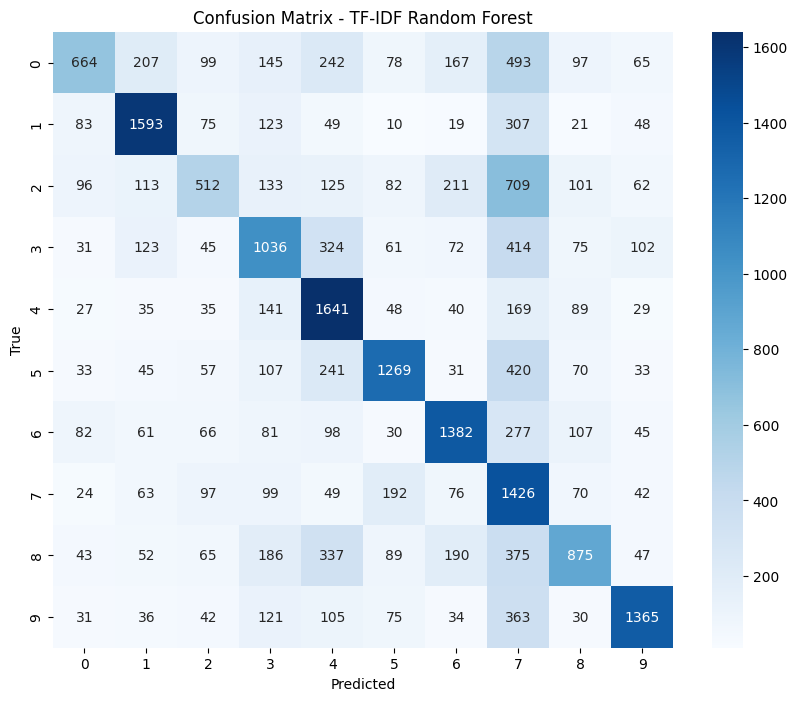

In [30]:
# TF-IDF + Random Forest: Training and evaluating Random Forest with TF-IDF features (CPU-based)
from sklearn.ensemble import RandomForestClassifier


# Hyperparameters
n_estimators = 500
max_depth = 15

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,n_jobs=-1, random_state=42)
rf.fit(X_tfidf_train, y_train)
y_pred = rf.predict(X_tfidf_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TF-IDF Random Forest')
plt.show()

Accuracy: 0.6679910714285714
F1 Macro: 0.6641610186915301
F1 Weighted: 0.6652553513906834
              precision    recall  f1-score   support

           0       0.56      0.49      0.52      2257
           1       0.81      0.81      0.81      2328
           2       0.51      0.45      0.48      2144
           3       0.62      0.63      0.62      2283
           4       0.67      0.75      0.71      2254
           5       0.72      0.75      0.74      2306
           6       0.73      0.73      0.73      2229
           7       0.64      0.71      0.67      2138
           8       0.60      0.55      0.57      2259
           9       0.78      0.79      0.79      2202

    accuracy                           0.67     22400
   macro avg       0.66      0.67      0.66     22400
weighted avg       0.66      0.67      0.67     22400



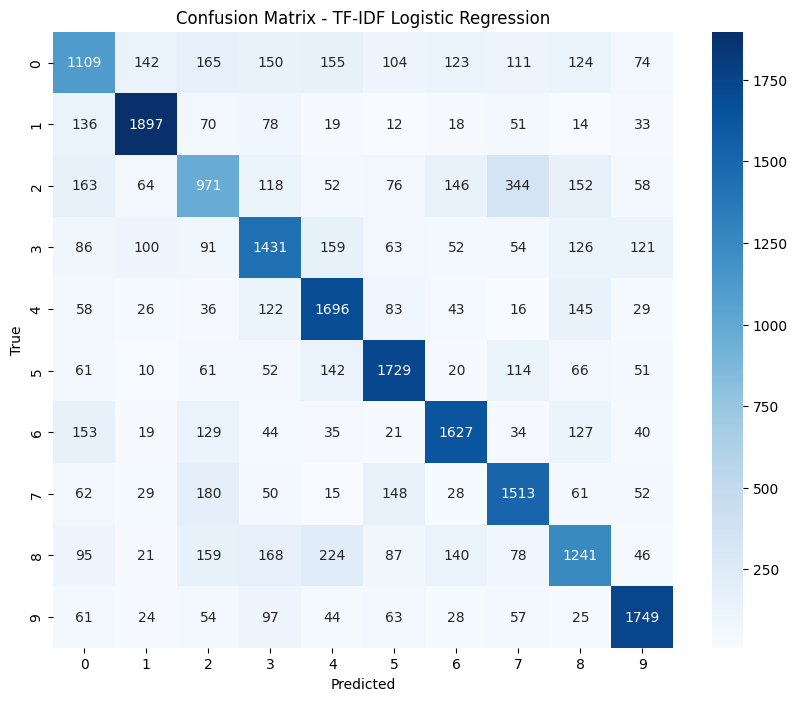

In [31]:
gc.collect()
# TF-IDF + Logistic Regression: Training and evaluating Logistic Regression with TF-IDF features (CPU-based)
from sklearn.linear_model import LogisticRegression


# Hyperparameters
max_iter = 500 #1000
C = 1.0

logreg = LogisticRegression(max_iter=max_iter, C=C, random_state=42)
logreg.fit(X_tfidf_train, y_train)
y_pred = logreg.predict(X_tfidf_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TF-IDF Logistic Regression')
plt.show()

Accuracy: 0.6550446428571428
F1 Macro: 0.6503058579462162
F1 Weighted: 0.6513653515095709
              precision    recall  f1-score   support

           0       0.55      0.49      0.52      2257
           1       0.79      0.82      0.81      2328
           2       0.53      0.43      0.47      2144
           3       0.59      0.60      0.60      2283
           4       0.59      0.79      0.68      2254
           5       0.71      0.74      0.73      2306
           6       0.72      0.71      0.72      2229
           7       0.65      0.68      0.66      2138
           8       0.60      0.52      0.56      2259
           9       0.78      0.74      0.76      2202

    accuracy                           0.66     22400
   macro avg       0.65      0.65      0.65     22400
weighted avg       0.65      0.66      0.65     22400



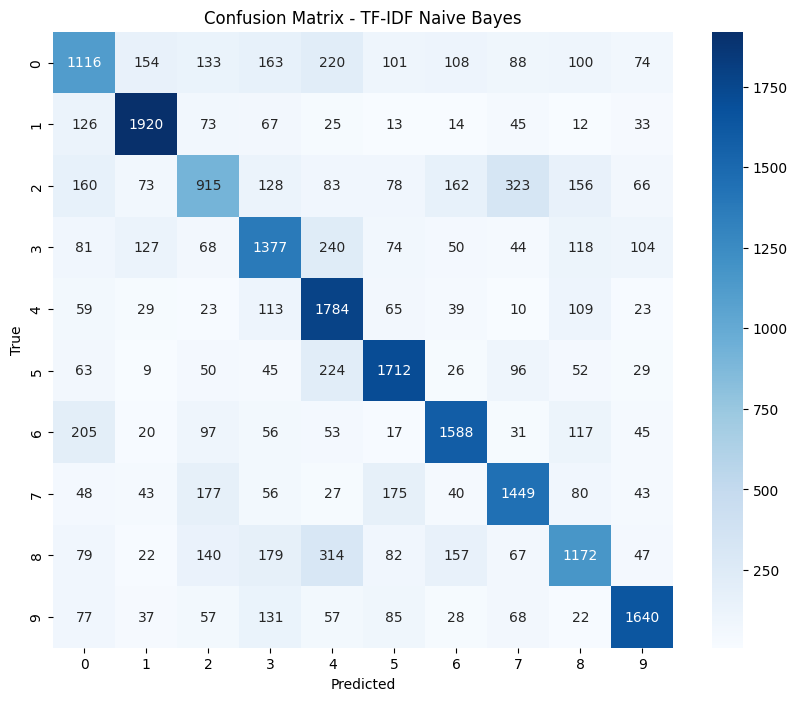

In [32]:
# TF-IDF + Naive Bayes: Training and evaluating Naive Bayes with TF-IDF features (CPU-based)
from sklearn.naive_bayes import MultinomialNB

# Hyperparameters
alpha = 1.0

nb = MultinomialNB(alpha=alpha)
nb.fit(X_tfidf_train, y_train)
y_pred = nb.predict(X_tfidf_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TF-IDF Naive Bayes')
plt.show()

Num GPUs Available:  1
Epoch 1/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5808 - loss: 1.2912 - val_accuracy: 0.6546 - val_loss: 1.0576
Epoch 2/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6517 - loss: 1.0807 - val_accuracy: 0.6633 - val_loss: 1.0303
Epoch 3/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6569 - loss: 1.0617 - val_accuracy: 0.6681 - val_loss: 1.0173
Epoch 4/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6614 - loss: 1.0471 - val_accuracy: 0.6709 - val_loss: 1.0100
Epoch 5/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6680 - loss: 1.0268 - val_accuracy: 0.6750 - val_loss: 0.9972
Epoch 6/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6693 - loss: 1.0188 - val_accuracy: 0.6716 - val_loss: 1.0025
Epoch 7/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6705 - loss: 1.0160 - val_accuracy: 0.6738 - val_loss: 0.9954
Epoch 8/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accur

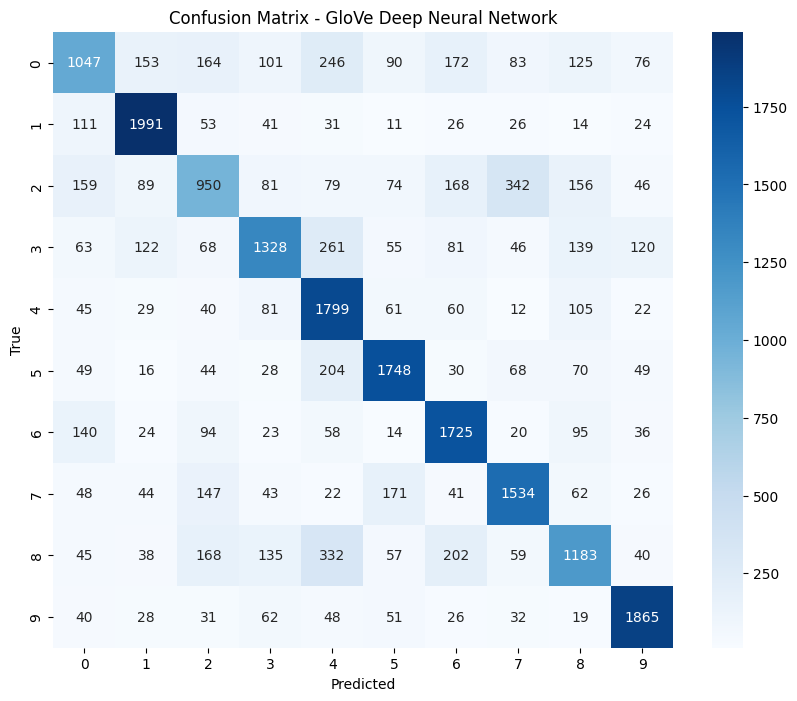

In [33]:
# GloVe + Deep Neural Network: Training and evaluating DNN with averaged GloVe embeddings using GPU

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Hyperparameters
hidden_units1 = 256 #512
hidden_units2 = 128 #256
dropout_rate = 0.2 #0.5
epochs = 10 #10
batch_size = 64 #32
learning_rate = 0.001

model = Sequential()
model.add(Dense(hidden_units1, input_shape=(100,), activation='relu')) # Corrected input_shape to 100
model.add(Dropout(dropout_rate))
model.add(Dense(hidden_units2, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_glove_avg_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_glove_avg_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GloVe Deep Neural Network')
plt.show()

Num GPUs Available:  1
Epoch 1/10
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - accuracy: 0.3247 - loss: 1.9572 - val_accuracy: 0.2040 - val_loss: 2.2664
Epoch 2/10
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.3027 - loss: 2.0015 - val_accuracy: 0.3442 - val_loss: 1.9107
Epoch 3/10
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - accuracy: 0.3210 - loss: 1.9660 - val_accuracy: 0.3781 - val_loss: 1.8090
Epoch 4/10
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.3375 - loss: 1.9157 - val_accuracy: 0.3081 - val_loss: 1.9626
Epoch 5/10
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.3087 - loss: 1.9839 - val_accuracy: 0.3204 - val_loss: 1.9652
Epoch 6/10
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.2699 - loss: 2.0670 - val_accuracy: 0.3563 - val_loss: 1.8878
Epoch 7/10
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.3174 - loss: 1.9645 - val_accuracy: 0.3176 - val_loss: 1.9525
Epoch 8/10
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - acc

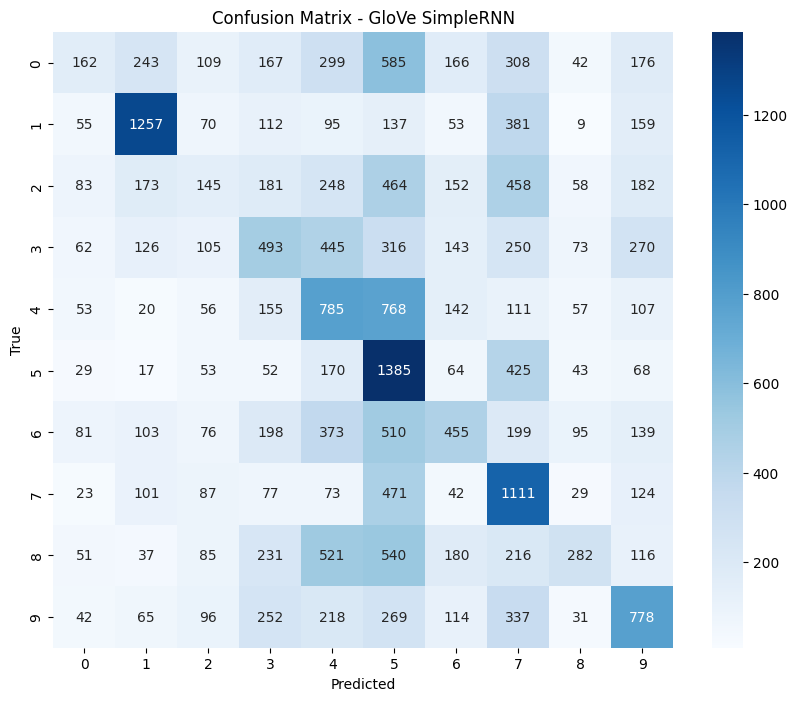

In [34]:
# GloVe + SimpleRNN: Training and evaluating SimpleRNN with GloVe embeddings using GPU

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Hyperparameters
rnn_units = 128 #128
trainable_embedding = False
epochs = 10
batch_size = 32
learning_rate = 0.001
embedding_dim = 100

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(SimpleRNN(rnn_units))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GloVe SimpleRNN')
plt.show()

Epoch 1/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step - accuracy: 0.5674 - loss: 1.3089 - val_accuracy: 0.6485 - val_loss: 1.0787
Epoch 2/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 135s 9ms/step - accuracy: 0.6596 - loss: 1.0472 - val_accuracy: 0.6618 - val_loss: 1.0383
Epoch 3/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 142s 9ms/step - accuracy: 0.6817 - loss: 0.9757 - val_accuracy: 0.6663 - val_loss: 1.0262
Epoch 4/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 142s 9ms/step - accuracy: 0.6971 - loss: 0.9288 - val_accuracy: 0.6684 - val_loss: 1.0221
Epoch 5/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - accuracy: 0.7054 - loss: 0.8962 - val_accuracy: 0.6654 - val_loss: 1.0305
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.6702232142857143
F1 Macro: 0.6645795738788638
F1 Weighted: 0.665633002799856
              precision    recall  f1-score   support

           0       0.56      0.47      0.51      2257
           1       0.82      0.81      0.81      2328
           2       0.59      0.41      0.48

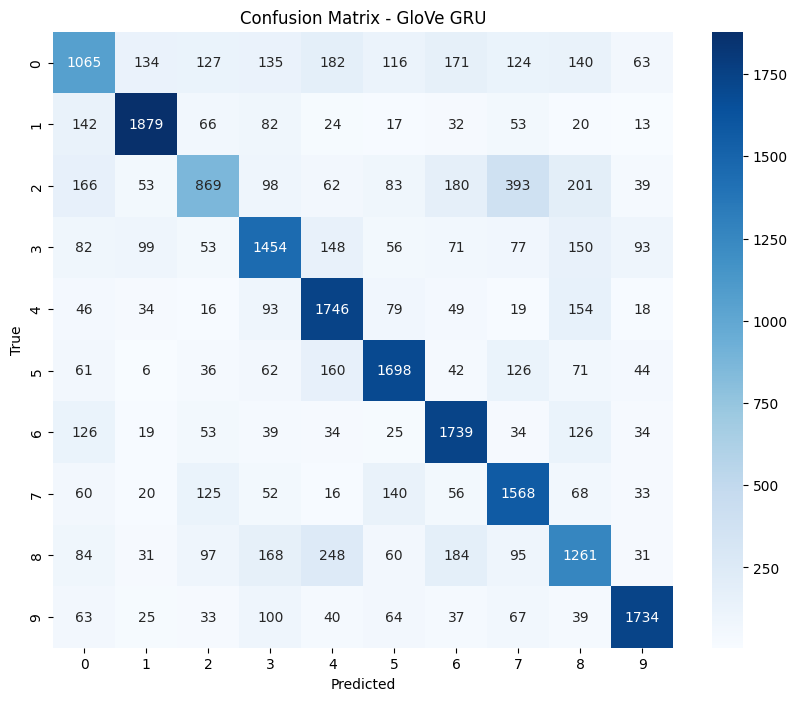

In [35]:
# GloVe + GRU: Training and evaluating GRU with GloVe embeddings using GPU
gc.collect()
from tensorflow.keras.layers import Embedding, GRU, Dense



# Hyperparameters
gru_units = 128
trainable_embedding = False
epochs = 5
batch_size = 16
learning_rate = 0.001
embedding_dim = 100


model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(GRU(gru_units))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GloVe GRU')
plt.show()

Num GPUs Available:  1
Epoch 1/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - accuracy: 0.5556 - loss: 1.3602 - val_accuracy: 0.6285 - val_loss: 1.1367
Epoch 2/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.6456 - loss: 1.0900 - val_accuracy: 0.6510 - val_loss: 1.0681
Epoch 3/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.6666 - loss: 1.0212 - val_accuracy: 0.6616 - val_loss: 1.0387
Epoch 4/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.6846 - loss: 0.9635 - val_accuracy: 0.6623 - val_loss: 1.0361
Epoch 5/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.6963 - loss: 0.9202 - val_accuracy: 0.6631 - val_loss: 1.0377
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.6695089285714285
F1 Macro: 0.6653866608341727
F1 Weighted: 0.666384604308767
              precision    recall  f1-score   support

           0       0.56      0.46      0.51      2257
           1       0.83      0.80      0.81      2328
           2       0.56      0.44 

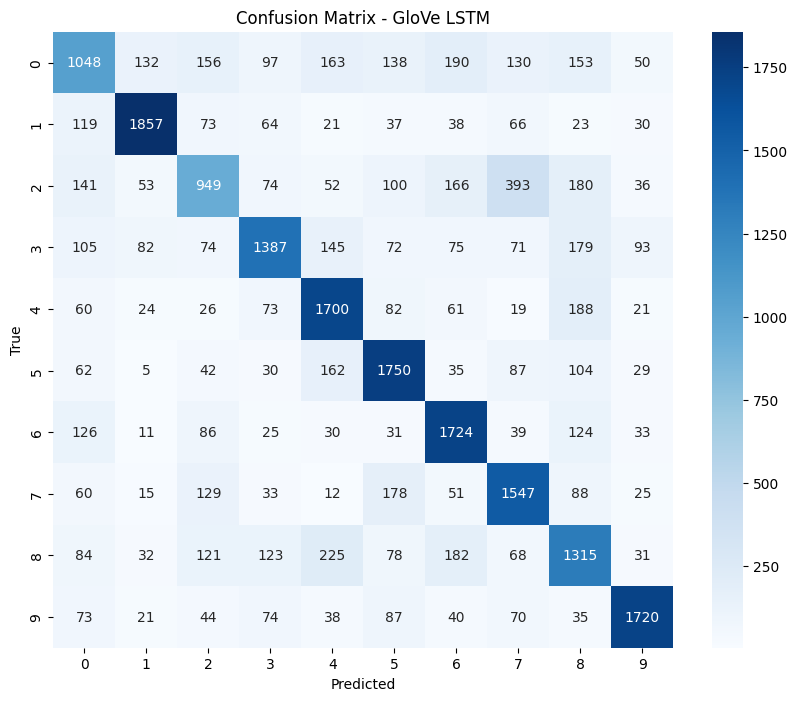

In [37]:
# GloVe + LSTM: Training and evaluating LSTM with GloVe embeddings using GPU
gc.collect()
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Hyperparameters
lstm_units = 128
trainable_embedding = False
epochs = 5
batch_size = 32
learning_rate = 0.001
embedding_dim = 100

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GloVe LSTM')
plt.show()

Epoch 1/5
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - accuracy: 0.3542 - loss: 1.8818 - val_accuracy: 0.4270 - val_loss: 1.6877
Epoch 2/5
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - accuracy: 0.3240 - loss: 1.9577 - val_accuracy: 0.3071 - val_loss: 1.9572
Epoch 3/5
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.3332 - loss: 1.8976 - val_accuracy: 0.2508 - val_loss: 2.1160
Epoch 4/5
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.2887 - loss: 2.0161 - val_accuracy: 0.3685 - val_loss: 1.8239
Epoch 5/5
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.3357 - loss: 1.8964 - val_accuracy: 0.2977 - val_loss: 2.0192
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Accuracy: 0.3023660714285714
F1 Macro: 0.28032576756677974
F1 Weighted: 0.28018759167117896
              precision    recall  f1-score   support

           0       0.23      0.14      0.17      2257
           1       0.30      0.49      0.37      2328
           2       0.22      0.10      0.14      

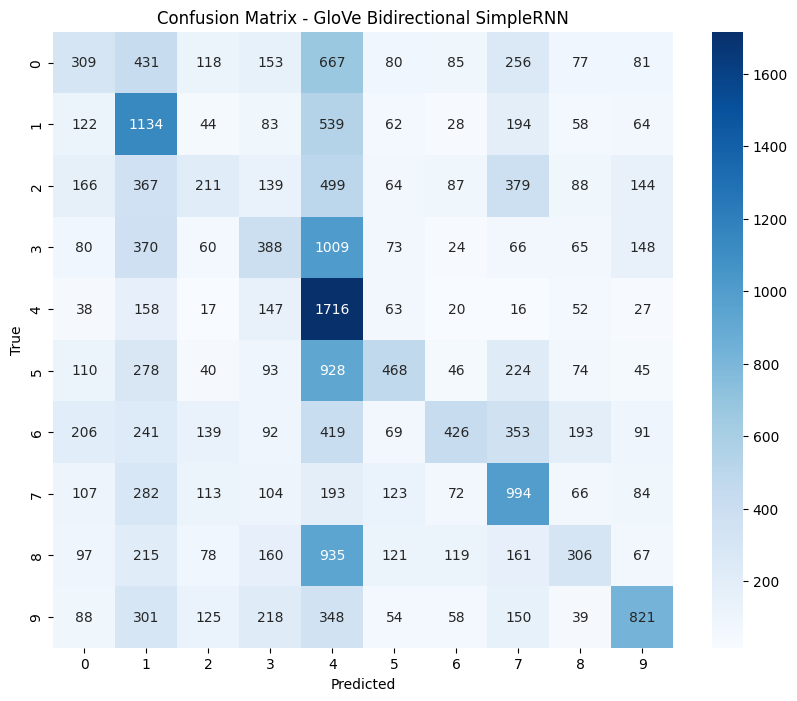

In [38]:
# GloVe + Bidirectional SimpleRNN: Training and evaluating Bidirectional SimpleRNN with GloVe embeddings using GPU
gc.collect()
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense


# Hyperparameters
rnn_units = 128
trainable_embedding = False
epochs = 5
batch_size = 64
learning_rate = 0.001
embedding_dim = 100

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(Bidirectional(SimpleRNN(rnn_units)))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GloVe Bidirectional SimpleRNN')
plt.show()

Epoch 1/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 135s 13ms/step - accuracy: 0.5549 - loss: 1.3465 - val_accuracy: 0.6441 - val_loss: 1.0926
Epoch 2/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 134s 13ms/step - accuracy: 0.6542 - loss: 1.0675 - val_accuracy: 0.6571 - val_loss: 1.0584
Epoch 3/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 142s 13ms/step - accuracy: 0.6689 - loss: 1.0155 - val_accuracy: 0.6560 - val_loss: 1.0567
Epoch 4/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 142s 13ms/step - accuracy: 0.6785 - loss: 0.9832 - val_accuracy: 0.6589 - val_loss: 1.0509
Epoch 5/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 133s 12ms/step - accuracy: 0.6897 - loss: 0.9500 - val_accuracy: 0.6604 - val_loss: 1.0502
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.6654017857142858
F1 Macro: 0.6604772256401057
F1 Weighted: 0.6615487520200588
              precision    recall  f1-score   support

           0       0.54      0.48      0.51      2257
           1       0.83      0.80      0.82      2328
           2       0.55      0.43   

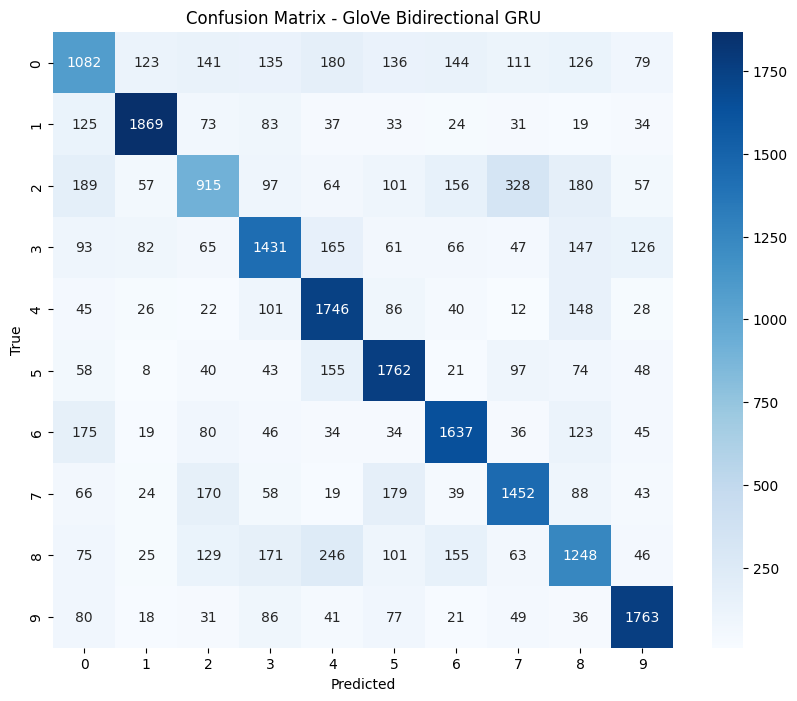

In [39]:
# GloVe + Bidirectional GRU: Training and evaluating Bidirectional GRU with GloVe embeddings using GPU
gc.collect()
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense


# Hyperparameters
gru_units = 64
trainable_embedding = False
epochs = 5
batch_size = 16
learning_rate = 0.001
embedding_dim = 100


model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(Bidirectional(GRU(gru_units)))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GloVe Bidirectional GRU')
plt.show()

Epoch 1/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step - accuracy: 0.5504 - loss: 1.3715 - val_accuracy: 0.6317 - val_loss: 1.1304
Epoch 2/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.6446 - loss: 1.0936 - val_accuracy: 0.6535 - val_loss: 1.0648
Epoch 3/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.6694 - loss: 1.0147 - val_accuracy: 0.6579 - val_loss: 1.0570
Epoch 4/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 85s 13ms/step - accuracy: 0.6851 - loss: 0.9591 - val_accuracy: 0.6625 - val_loss: 1.0427
Epoch 5/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - accuracy: 0.7027 - loss: 0.9026 - val_accuracy: 0.6641 - val_loss: 1.0526
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.6654910714285714
F1 Macro: 0.6602137775339622
F1 Weighted: 0.6612103867234062
              precision    recall  f1-score   support

           0       0.59      0.46      0.51      2257
           1       0.79      0.83      0.81      2328
           2       0.51      0.48      0.49      21

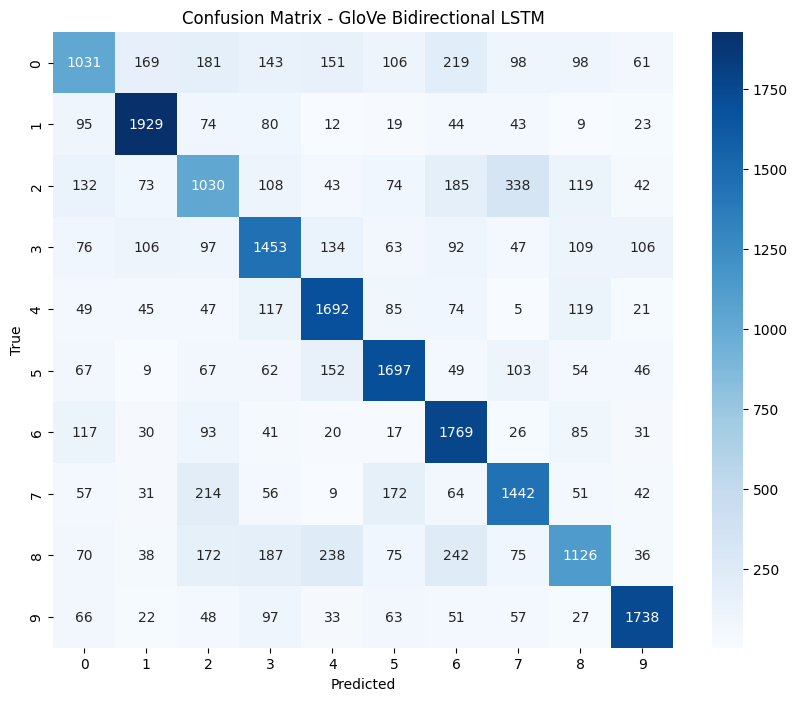

In [40]:
# GloVe + Bidirectional LSTM: Training and evaluating Bidirectional LSTM with GloVe embeddings
gc.collect()
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense


# Hyperparameters
lstm_units = 128
trainable_embedding = False
epochs = 5
batch_size = 32
learning_rate = 0.001
embedding_dim = 100


model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GloVe Bidirectional LSTM')
plt.show()

Epoch 1/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6025 - loss: 1.2389 - val_accuracy: 0.6676 - val_loss: 1.0254
Epoch 2/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.6504 - loss: 1.0970 - val_accuracy: 0.6756 - val_loss: 1.0006
Epoch 3/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6571 - loss: 1.0818 - val_accuracy: 0.6730 - val_loss: 1.0061
Epoch 4/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.6600 - loss: 1.0709 - val_accuracy: 0.6787 - val_loss: 0.9902
Epoch 5/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6620 - loss: 1.0665 - val_accuracy: 0.6771 - val_loss: 0.9897
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.6789285714285714
F1 Macro: 0.6646609093044298
F1 Weighted: 0.6657333272855993
              precision    recall  f1-score   support

           0       0.70      0.39      0.50      2257
           1       0.76      0.89      0.82      2328
           2       0.62      0.34      0.44   

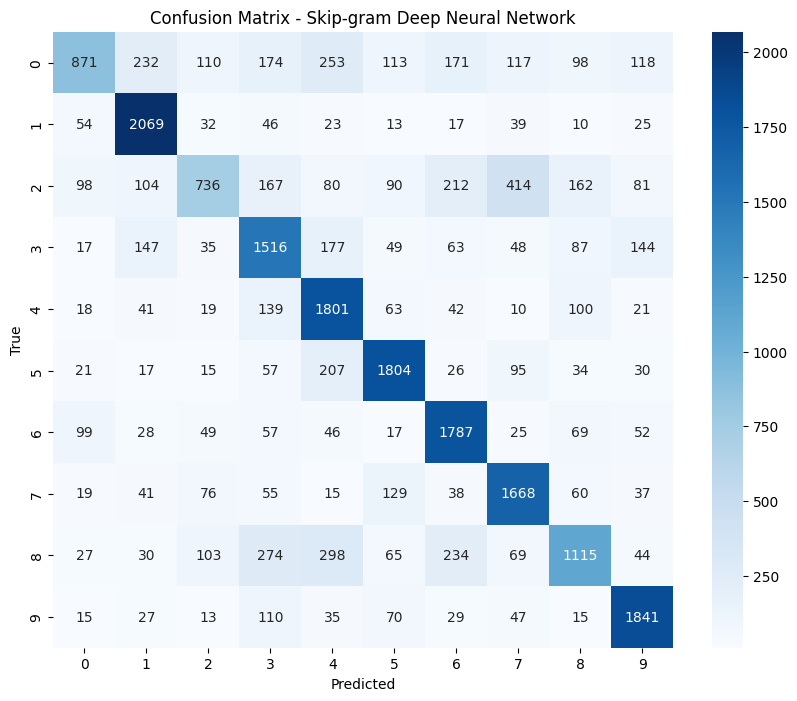

In [46]:
# Skip-gram + Deep Neural Network: Training and evaluating DNN with averaged Skip-gram embeddings
gc.collect()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Hyperparameters
hidden_units1 = 512
hidden_units2 = 256
dropout_rate = 0.5
epochs = 5
batch_size = 16
learning_rate = 0.001
embedding_dim = 50  # Update embedding_dim to match the Skip-gram embedding dimension

model = Sequential()
model.add(Dense(hidden_units1, input_shape=(embedding_dim,), activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(hidden_units2, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_sg_avg_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_sg_avg_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skip-gram Deep Neural Network')
plt.show()

Epoch 1/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - accuracy: 0.3722 - loss: 1.8227 - val_accuracy: 0.4029 - val_loss: 1.7457
Epoch 2/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.3714 - loss: 1.8487 - val_accuracy: 0.3440 - val_loss: 1.9047
Epoch 3/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.3206 - loss: 1.9713 - val_accuracy: 0.3610 - val_loss: 1.8421
Epoch 4/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.2967 - loss: 2.0272 - val_accuracy: 0.3630 - val_loss: 1.8705
Epoch 5/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.3284 - loss: 1.9451 - val_accuracy: 0.3241 - val_loss: 1.9232
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.3289732142857143
F1 Macro: 0.31639795687959305
F1 Weighted: 0.317612972946357
              precision    recall  f1-score   support

           0       0.25      0.16      0.19      2257
           1       0.50      0.55      0.53      2328
           2       0.23      0.08      0.12      2144
  

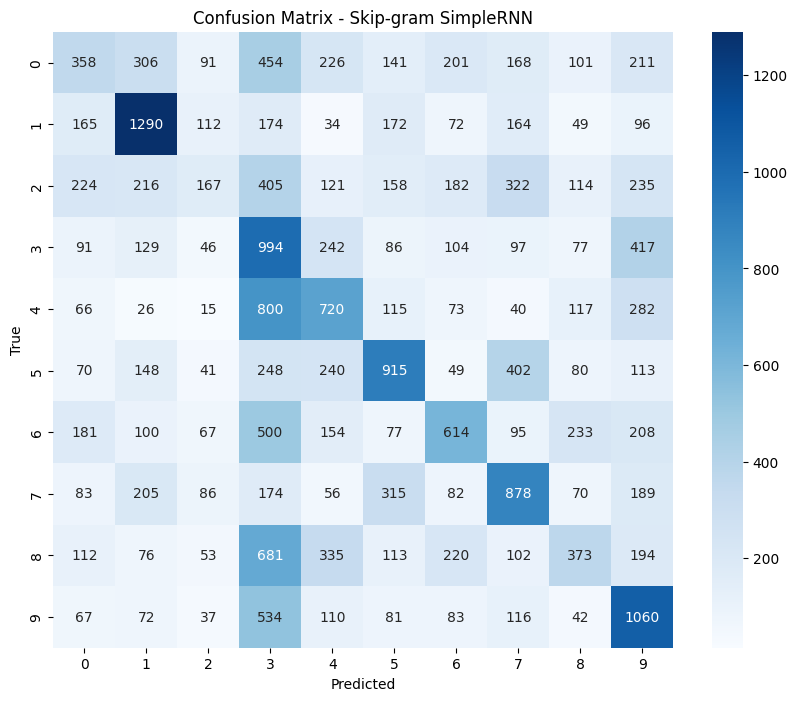

In [47]:
# Skip-gram + SimpleRNN: Training and evaluating SimpleRNN with Skip-gram embeddings
gc.collect()
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense


# Hyperparameters
rnn_units = 128
trainable_embedding = False
epochs = 5
batch_size = 32
learning_rate = 0.001

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(SimpleRNN(rnn_units))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skip-gram SimpleRNN')
plt.show()

Epoch 1/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.5624 - loss: 1.3197 - val_accuracy: 0.6411 - val_loss: 1.1005
Epoch 2/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 76s 9ms/step - accuracy: 0.6465 - loss: 1.0822 - val_accuracy: 0.6543 - val_loss: 1.0579
Epoch 3/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.6604 - loss: 1.0441 - val_accuracy: 0.6597 - val_loss: 1.0377
Epoch 4/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 87s 10ms/step - accuracy: 0.6701 - loss: 1.0090 - val_accuracy: 0.6634 - val_loss: 1.0310
Epoch 5/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - accuracy: 0.6780 - loss: 0.9850 - val_accuracy: 0.6653 - val_loss: 1.0208
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.6680357142857143
F1 Macro: 0.6621560916549905
F1 Weighted: 0.6631116689404953
              precision    recall  f1-score   support

           0       0.59      0.48      0.53      2257
           1       0.79      0.84      0.82      2328
           2       0.55      0.45      0.50      2144


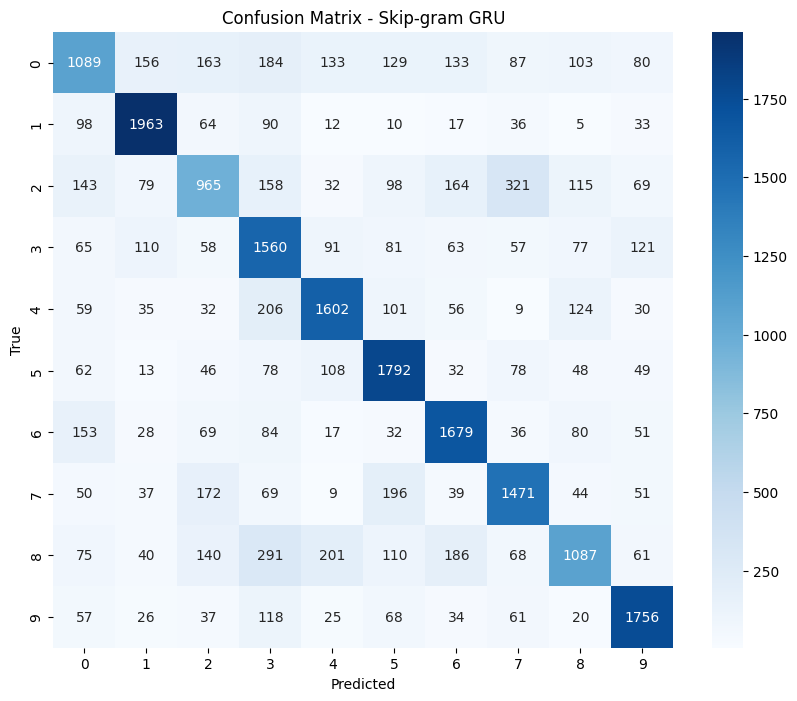

In [48]:
# Skip-gram + GRU: Training and evaluating GRU with Skip-gram embeddings
gc.collect()
from tensorflow.keras.layers import Embedding, GRU, Dense
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# Hyperparameters
gru_units = 128
trainable_embedding = False
epochs = 5
batch_size = 32
learning_rate = 0.001

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(GRU(gru_units))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skip-gram GRU')
plt.show()

Epoch 1/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - accuracy: 0.5584 - loss: 1.3576 - val_accuracy: 0.6290 - val_loss: 1.1419
Epoch 2/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.6416 - loss: 1.1072 - val_accuracy: 0.6473 - val_loss: 1.0783
Epoch 3/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - accuracy: 0.6560 - loss: 1.0562 - val_accuracy: 0.6572 - val_loss: 1.0511
Epoch 4/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.6644 - loss: 1.0225 - val_accuracy: 0.6614 - val_loss: 1.0359
Epoch 5/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.6734 - loss: 0.9972 - val_accuracy: 0.6656 - val_loss: 1.0253
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.6661607142857143
F1 Macro: 0.6614924481141802
F1 Weighted: 0.6625263722769309
              precision    recall  f1-score   support

           0       0.56      0.51      0.53      2257
           1       0.81      0.82      0.81      2328
           2       0.53      0.46      0.49      2144
 

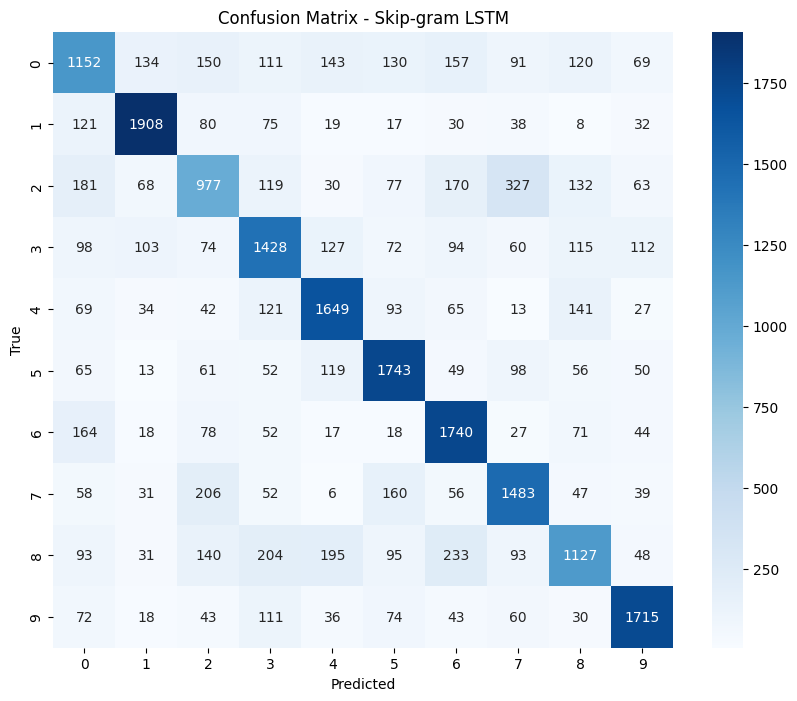

In [49]:
# Skip-gram + LSTM: Training and evaluating LSTM with Skip-gram embeddings
gc.collect()
from tensorflow.keras.layers import Embedding, LSTM, Dense


# Hyperparameters
lstm_units = 128
trainable_embedding = False
epochs = 5
batch_size = 32
learning_rate = 0.001

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skip-gram LSTM')
plt.show()

Epoch 1/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - accuracy: 0.3567 - loss: 1.8715 - val_accuracy: 0.2987 - val_loss: 1.9995
Epoch 2/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 133s 15ms/step - accuracy: 0.3545 - loss: 1.8885 - val_accuracy: 0.3566 - val_loss: 1.8612
Epoch 3/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - accuracy: 0.3404 - loss: 1.9162 - val_accuracy: 0.3401 - val_loss: 1.9151
Epoch 4/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.3339 - loss: 1.9285 - val_accuracy: 0.3678 - val_loss: 1.8558
Epoch 5/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.3622 - loss: 1.8600 - val_accuracy: 0.3822 - val_loss: 1.7976
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.38705357142857144
F1 Macro: 0.3543429424076225
F1 Weighted: 0.35525533808070436
              precision    recall  f1-score   support

           0       0.46      0.05      0.09      2257
           1       0.40      0.65      0.49      2328
           2       0.19      0.24      0.21     

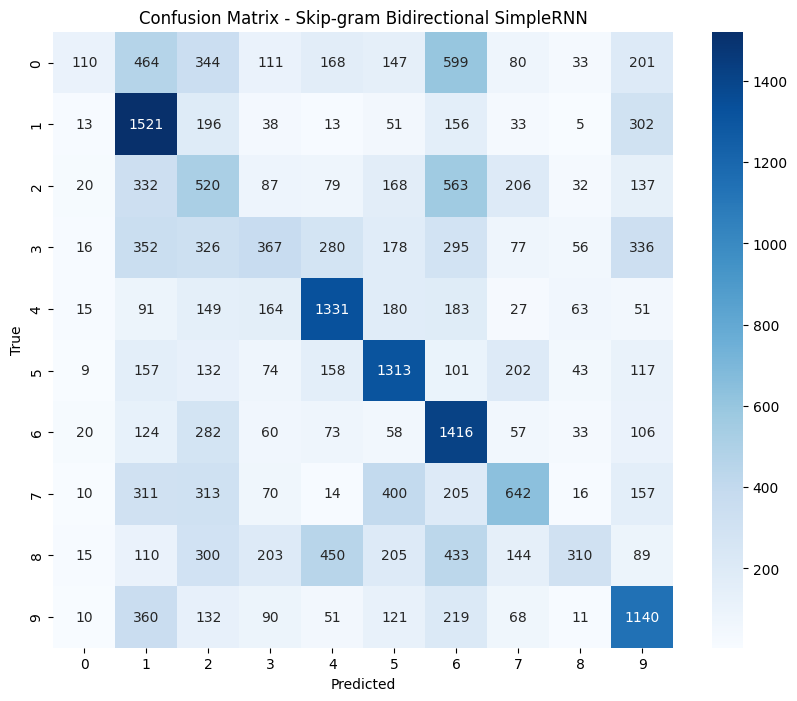

In [50]:
# Skip-gram + Bidirectional SimpleRNN: Training and evaluating Bidirectional SimpleRNN with Skip-gram embeddings
gc.collect()
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense



# Hyperparameters
rnn_units = 128
trainable_embedding = False
epochs = 5
batch_size = 32
learning_rate = 0.001

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(Bidirectional(SimpleRNN(rnn_units)))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skip-gram Bidirectional SimpleRNN')
plt.show()

Epoch 1/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - accuracy: 0.5606 - loss: 1.3262 - val_accuracy: 0.6452 - val_loss: 1.0909
Epoch 2/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 70s 14ms/step - accuracy: 0.6488 - loss: 1.0804 - val_accuracy: 0.6508 - val_loss: 1.0717
Epoch 3/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - accuracy: 0.6630 - loss: 1.0357 - val_accuracy: 0.6568 - val_loss: 1.0446
Epoch 4/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - accuracy: 0.6700 - loss: 1.0065 - val_accuracy: 0.6605 - val_loss: 1.0347
Epoch 5/5
5040/5040 ━━━━━━━━━━━━━━━━━━━━ 77s 13ms/step - accuracy: 0.6779 - loss: 0.9795 - val_accuracy: 0.6649 - val_loss: 1.0264
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.6701339285714286
F1 Macro: 0.6626029425585372
F1 Weighted: 0.6636486778581637
              precision    recall  f1-score   support

           0       0.59      0.46      0.52      2257
           1       0.76      0.87      0.81      2328
           2       0.58      0.43      0.49      21

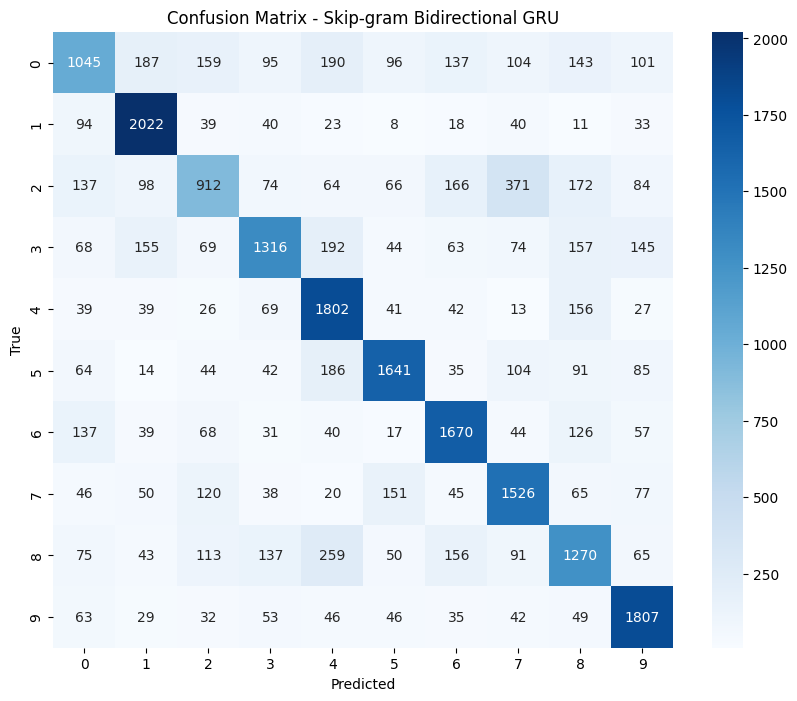

In [51]:
# Skip-gram + Bidirectional GRU: Training and evaluating Bidirectional GRU with Skip-gram embeddings
gc.collect()
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense



# Hyperparameters
gru_units = 128
trainable_embedding = False
epochs = 5
batch_size = 32
learning_rate = 0.001

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(Bidirectional(GRU(gru_units)))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skip-gram Bidirectional GRU')
plt.show()

Epoch 1/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 137s 13ms/step - accuracy: 0.5626 - loss: 1.3468 - val_accuracy: 0.6386 - val_loss: 1.0996
Epoch 2/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 133s 13ms/step - accuracy: 0.6452 - loss: 1.0895 - val_accuracy: 0.6561 - val_loss: 1.0537
Epoch 3/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.6643 - loss: 1.0290 - val_accuracy: 0.6591 - val_loss: 1.0465
Epoch 4/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.6752 - loss: 0.9953 - val_accuracy: 0.6582 - val_loss: 1.0405
Epoch 5/5
10080/10080 ━━━━━━━━━━━━━━━━━━━━ 134s 13ms/step - accuracy: 0.6840 - loss: 0.9629 - val_accuracy: 0.6690 - val_loss: 1.0194
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.6690625
F1 Macro: 0.661782843081469
F1 Weighted: 0.6628601402940951
              precision    recall  f1-score   support

           0       0.59      0.45      0.51      2257
           1       0.79      0.84      0.81      2328
           2       0.52      0.46      0.49   

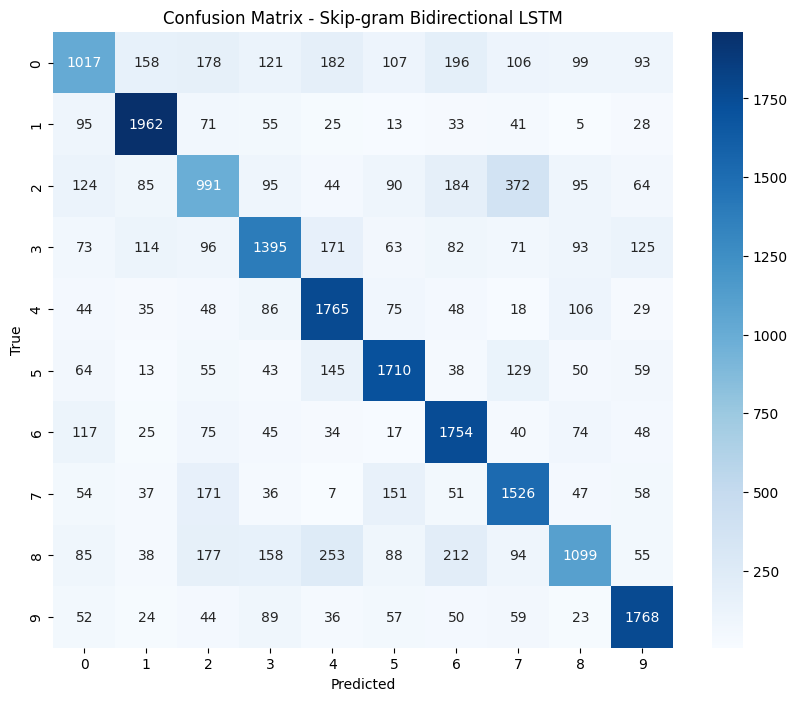

In [52]:
# Skip-gram + Bidirectional LSTM: Training and evaluating Bidirectional LSTM with Skip-gram embeddings
gc.collect()
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense


# Hyperparameters
lstm_units = 128
trainable_embedding = False
epochs = 5
batch_size = 32
learning_rate = 0.001

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding))
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model on GPU
with tf.device('/GPU:0'):
    model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Predict on GPU
with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Skip-gram Bidirectional LSTM')
plt.show()

In [52]:
gc.collect()

# **BOW**

In [69]:
# Bag of Words (BoW): Creating BoW representations with limited features
from sklearn.feature_extraction.text import CountVectorizer

# Hyperparameter
max_features_bow = 5000  # 10000

vectorizer_bow = CountVectorizer(max_features=max_features_bow)
X_bow_train = vectorizer_bow.fit_transform(X_text_train)
X_bow_test = vectorizer_bow.transform(X_text_test)

gc.collect()

0

Accuracy: 0.6633482142857143
F1 Macro: 0.6600388156567072
F1 Weighted: 0.6610375325992814
              precision    recall  f1-score   support

           0       0.56      0.49      0.52      2257
           1       0.80      0.83      0.82      2328
           2       0.53      0.45      0.48      2144
           3       0.51      0.71      0.60      2283
           4       0.62      0.77      0.69      2254
           5       0.76      0.74      0.75      2306
           6       0.76      0.70      0.73      2229
           7       0.70      0.66      0.68      2138
           8       0.65      0.49      0.56      2259
           9       0.77      0.78      0.78      2202

    accuracy                           0.66     22400
   macro avg       0.67      0.66      0.66     22400
weighted avg       0.67      0.66      0.66     22400



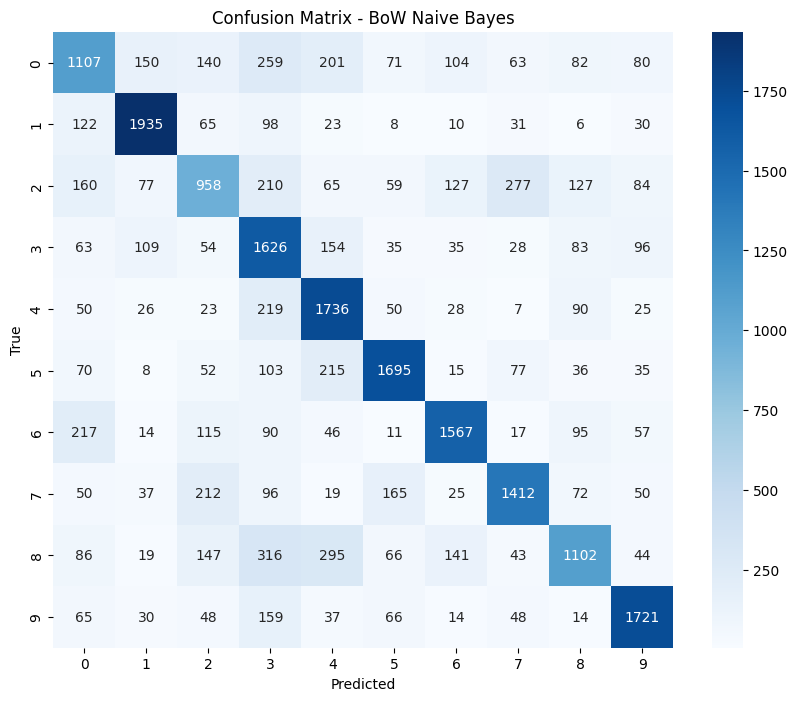

In [70]:
# BoW + Naive Bayes: Training and evaluating Naive Bayes with BoW features (CPU-based)
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# Hyperparameters
alpha = 1.0

nb = MultinomialNB(alpha=alpha)
nb.fit(X_bow_train, y_train)
y_pred = nb.predict(X_bow_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BoW Naive Bayes')
plt.show()

Accuracy: 0.5225446428571429
F1 Macro: 0.5234434363518582
F1 Weighted: 0.5254468158808207
              precision    recall  f1-score   support

           0       0.60      0.29      0.40      2257
           1       0.68      0.71      0.70      2328
           2       0.60      0.22      0.32      2144
           3       0.75      0.35      0.48      2283
           4       0.50      0.73      0.60      2254
           5       0.67      0.56      0.61      2306
           6       0.63      0.63      0.63      2229
           7       0.25      0.71      0.36      2138
           8       0.55      0.39      0.45      2259
           9       0.76      0.62      0.68      2202

    accuracy                           0.52     22400
   macro avg       0.60      0.52      0.52     22400
weighted avg       0.60      0.52      0.53     22400



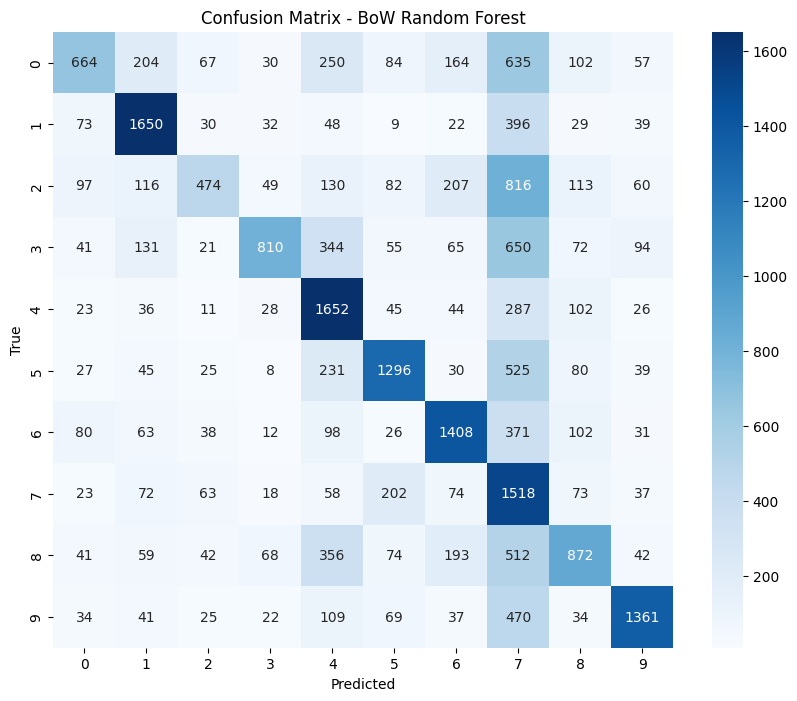

In [71]:
# BoW + Random Forest: Training and evaluating Random Forest with BoW features (CPU-based)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# Hyperparameters
n_estimators = 100
max_depth = 15

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
rf.fit(X_bow_train, y_train)
y_pred = rf.predict(X_bow_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BoW Random Forest')
plt.show()

Accuracy: 0.6476785714285714
F1 Macro: 0.6437463967743358
F1 Weighted: 0.6448704252183519
              precision    recall  f1-score   support

           0       0.51      0.45      0.48      2257
           1       0.80      0.81      0.80      2328
           2       0.47      0.44      0.46      2144
           3       0.59      0.65      0.62      2283
           4       0.65      0.72      0.68      2254
           5       0.71      0.71      0.71      2306
           6       0.72      0.70      0.71      2229
           7       0.62      0.67      0.64      2138
           8       0.58      0.49      0.54      2259
           9       0.77      0.81      0.79      2202

    accuracy                           0.65     22400
   macro avg       0.64      0.65      0.64     22400
weighted avg       0.64      0.65      0.64     22400



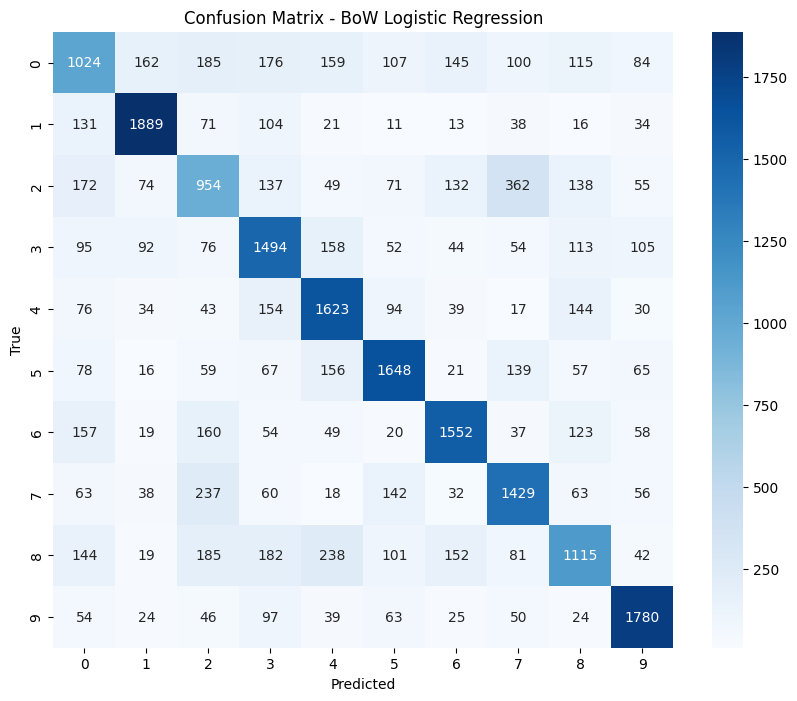

In [72]:
# BoW + Logistic Regression: Training and evaluating Logistic Regression with BoW features (CPU-based)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Hyperparameters
max_iter = 500  #1000
C = 1.0

logreg = LogisticRegression(max_iter=max_iter, C=C, random_state=42)
logreg.fit(X_bow_train, y_train)
y_pred = logreg.predict(X_bow_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"F1 Macro: {f1_macro}")
print(f"F1 Weighted: {f1_weighted}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BoW Logistic Regression')
plt.show()